In [1]:
import os
import cv2
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from glob import glob

In [2]:
path_main = '.\CatsNDogs\Data_cats_and_dogs'
path_cats = os.path.join(path_main, 'Cat')
path_dogs = os.path.join(path_main, 'Dog')

images_cats = glob(path_cats + '/*.*')
images_dogs = glob(path_dogs + '/*.*')

images_cats_4000 = images_cats[:4000]
images_dogs_4000 = images_dogs[:4000]

In [3]:
images_list = [x for x in images_cats_4000]
images_list.extend([x for x in images_dogs_4000])

dataframe = pd.DataFrame(np.concatenate([
    ['0'] * len(images_cats_4000),
    ['1'] * len(images_dogs_4000),
]), columns=['label'])

dataframe['image'] = [x for x in images_list]
dataframe.head()

,label,image
0,0,F:\Django\CatsNDogs\Data_cats_and_dogs\Cat\0.jpg
1,0,F:\Django\CatsNDogs\Data_cats_and_dogs\Cat\1.jpg
2,0,F:\Django\CatsNDogs\Data_cats_and_dogs\Cat\124...
3,0,F:\Django\CatsNDogs\Data_cats_and_dogs\Cat\124...
4,0,F:\Django\CatsNDogs\Data_cats_and_dogs\Cat\124...


In [4]:
image_list_resized = []
index_list = []
labels_list = list(dataframe['label'])

index = 0
counter = 0
for img in tqdm(images_list):
    img = cv2.imread(img)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (200, 200))
        image_list_resized.append(img)
    except:
        counter += 1
        index_list.append(index)
    index += 1

print(f'Total {counter} removed due to unknow error of cv2')

X = np.array(image_list_resized)

100%|██████████| 8000/8000 [01:32<00:00, 86.64it/s] 


Total 15 removed due to unknow error of cv2


In [5]:
#labels_list = list(dataframe['label'])
for i in index_list:
    labels_list[i] = '5'

labels_list = [x for x in labels_list if x != '5']
y = np.array(labels_list)

In [6]:
print(f'X shape - {X.shape} \ny shape - {y.shape}')

X shape - (7985, 200, 200, 3) 
y shape - (7985,)


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = y.reshape(-1, 1)

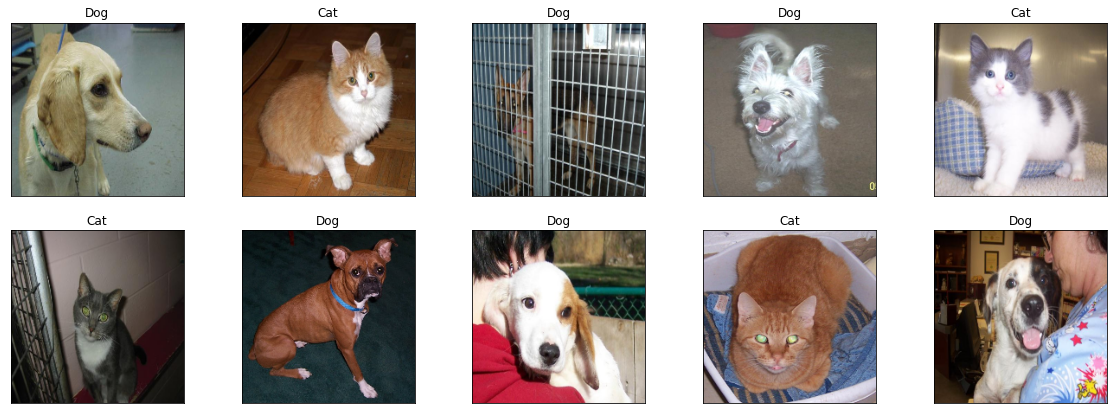

In [8]:
ind = np.random.randint(0, X.shape[0], 10)
i = 1
plt.figure(figsize=(20, 7))
for index in ind:
  plt.subplot(2, 5, i)
  plt.imshow(X[index])
  plt.title('Dog' if y[index][0] == 1 else 'Cat')
  plt.xticks([])
  plt.yticks([])
  i += 1

In [9]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications import xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [10]:
y = y.reshape(-1, )
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (5589, 200, 200, 3)
y_train shape:  (5589,)
X_test shape:  (2396, 200, 200, 3)
y_test shape:  (2396,)


In [11]:
base = xception.Xception(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
x = base.output
x = layers.GlobalAveragePooling2D()(x)

In [12]:
head = layers.Dense(1, activation='sigmoid')(x)

model_xception = models.Model(inputs=base.input, outputs=head)

In [13]:
model_xception.compile(
    optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
    loss=losses.BinaryCrossentropy(), 
    metrics=['accuracy'],
)

In [14]:
BATCH_SIZE = 16
EPOCHS = 5

In [15]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=3)

tf.debugging.set_log_device_placement(True)
try:
  with tf.device('/device:GPU:0'): 
    history = model_xception.fit(
        x=X_train, 
        y=y_train, 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        validation_data=(X_test, y_test), 
        verbose=2)
except RuntimeError as e:
  print(e)

model_xception.save('model_xception.h5')

Epoch 1/5
350/350 - 252s - loss: 0.1006 - accuracy: 0.9633 - val_loss: 0.0427 - val_accuracy: 0.9841
Epoch 2/5
350/350 - 248s - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.0586 - val_accuracy: 0.9795
Epoch 3/5
350/350 - 249s - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.0505 - val_accuracy: 0.9829
Epoch 4/5
350/350 - 248s - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0445 - val_accuracy: 0.9804
Epoch 5/5
350/350 - 248s - loss: 0.0091 - accuracy: 0.9977 - val_loss: 0.0418 - val_accuracy: 0.9862


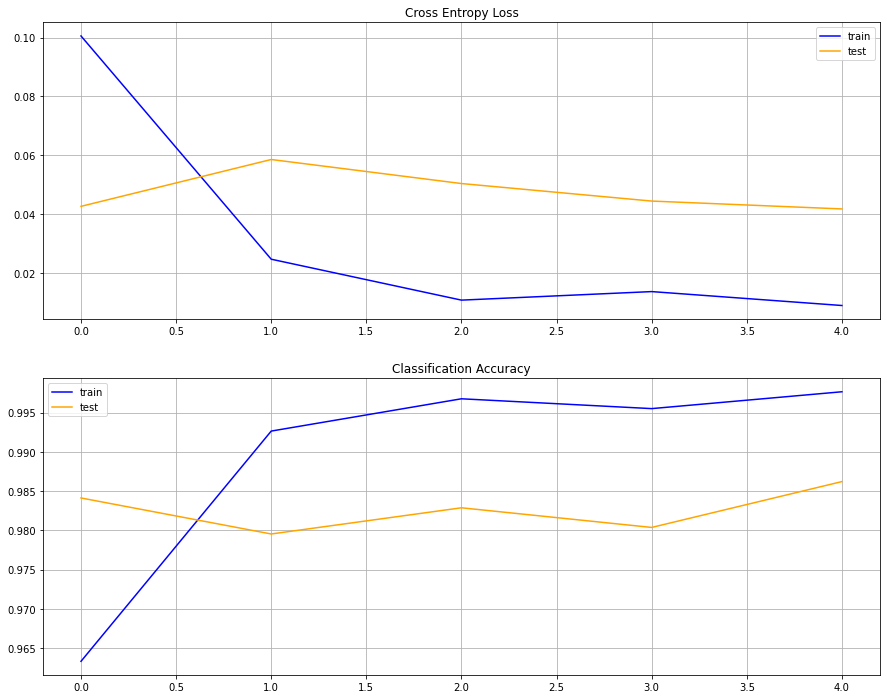

In [16]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.set_title('Cross Entropy Loss')
ax1.plot(history.history['loss'], color='blue', label='train')
ax1.plot(history.history['val_loss'], color='orange', label='test')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.set_title('Classification Accuracy')
ax2.plot(history.history['accuracy'], color='blue', label='train')
ax2.plot(history.history['val_accuracy'], color='orange', label='test')
ax2.legend()

In [17]:
prediction = model_xception.predict(X_test)

In [18]:
prediction

array([[0.99999416],
       [0.00111632],
       [0.9996803 ],
       ...,
       [0.9999906 ],
       [0.99999475],
       [0.9999639 ]], dtype=float32)

In [19]:
y_test

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [25]:
prediction = prediction.reshape(-1, )
prediction = np.round(prediction, 1).astype('int16')
prediction

array([1, 0, 1, ..., 1, 1, 1], dtype=int16)

In [26]:
print(f'Accuracy score of Xception model: {accuracy_score(y_test, prediction)}')
print(f'Classification report: {classification_report(y_test, prediction)}')

Accuracy score of Xception model: 0.9757929883138564
Classification report:               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1231
           1       0.99      0.96      0.97      1165

    accuracy                           0.98      2396
   macro avg       0.98      0.98      0.98      2396
weighted avg       0.98      0.98      0.98      2396



<AxesSubplot:>

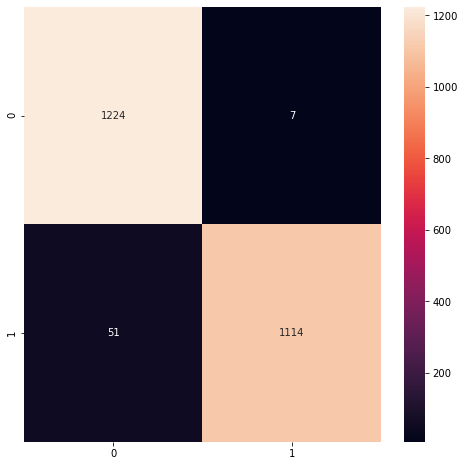

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d")